In [ ]:
#default_exp training

# Imports

In [ ]:
#export
from tqdm.auto import tqdm
from speechsep.core import *
from speechsep.masks import *
from speechsep.pipe import *
from speechsep.utils import *
from speechsep.data import *
from speechsep.imports import *
from speechsep.models import *

In [ ]:
#export
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Enable Cuda

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

# File Paths

In [ ]:
#export
#fn = Path("../../data/clips/")
fn = Path("/run/media/holydemon/HolySSD/datawav/")
pipe = AudioPipe(fn)

# Dataset/DataLoader

In [ ]:
#export
class Tensorify(Transform):
    def encodes(self, x, cuda=True):
        tnsr = complex2real(x.data) if hasattr(x, "data") else complex2real(x)
        return torch.cuda.FloatTensor(tnsr)

class AudioDataset(Dataset):
    @delegates(AudioPipe)
    def __init__(self, fn, **kwargs):
        self.fn = fn
        self.pipe = AudioPipe(fn, **kwargs)
        self.n_samples = len(get_audio_files(fn))
    
    def __getitem__(self, index):
        x,y = self.pipe(index)
        x,y = Tensorify()(x),Tensorify()(y)
        return x,y
    
    def __len__(self):
        return self.n_samples

# Loss Function

In [ ]:
#export
def loss_func(x,y):
    if (x[0]!=x[0]).any() or (x[1]!=x[1]).any():
        raise AssertionError(f'Loss x contained nan')
    if (y[0]!=y[0]).any() or (y[1]!=y[1]).any():
        raise AssertionError(f'Loss y contained nan')
    loss = nn.MSELoss()
    min_loss = min(loss(x[0],y[0]) + loss(x[1],y[1]), loss(x[0],y[1]) + loss(x[1],y[0]))
    if (min_loss!=min_loss).any():
        raise AssertionError(f'Loss returned contained nan')
    return min_loss

# Training Prep

In [ ]:
#export
bs = 1
shuffle=True
workers=0
seed=42
torch.manual_seed(seed);

In [ ]:
#export
dataset = AudioDataset(fn)
n = len(dataset)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, [1000, 500, n-1500])
train_dl = DataLoader(dataset=train_ds, batch_size=bs, shuffle=shuffle, num_workers=workers)
valid_dl = DataLoader(dataset=valid_ds, batch_size=1, shuffle=shuffle, num_workers=workers)
test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=shuffle, num_workers=workers)

dataiter = iter(train_dl)
data = dataiter.next()

In [ ]:
#export
model = U_Net(img_ch=2, output_ch=2).cuda()

In [ ]:
#export
n_epochs = 8
n_samples = len(train_dl.dataset)
n_iter = math.ceil(n_samples/bs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop

In [ ]:
#export
model.train()
for epoch in range(n_epochs):
    for i, (xb, yb) in tqdm(enumerate(train_dl)):
        if (xb!=xb).any():
            raise AssertionError(f'Input contained nan during epoch {epoch} and step {i}')
        out = model(xb)
        if (out!=out).any():
            raise AssertionError(f'Output contained nan during epoch {epoch} and step {i}')
        mask1 = MaskBinary(out[:,:1,:,:])
        mask2 = MaskBinary(out[:,1:,:,:])
        sep = mask1*xb, mask2*xb
        loss = loss_func(sep, yb)

        #if (i+1)%5==0:
        #    print(f'epoch {epoch}: step {(i+1)/n_iter}')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    torch.save(model.state_dict(), f"../models/unet_{epoch+1}_complex")
    print(f"epoch {epoch+1} Finished, saved model")

In [ ]:
afsdfafds

In [ ]:
#export
model.cpu()
model.eval()
for i, (xb, yb) in tqdm(enumerate(valid_dl)):
    xb,yb = xb.detach().cpu(), [yb[i].detach().cpu() for i in range(2)]
    out = model(xb)
    mask1 = MaskBinary(out[:,:1,:,:])
    mask2 = MaskBinary(out[:,1:,:,:])
    
    sep = mask1*xb, mask2*xb
    sep = [sep[i].detach().cpu().squeeze() for i in range(len(sep))]
    sep = [real2complex(sep[i]) for i in range(len(sep))]
    spec1, spec2 = SpecImage(sep[0], 22050), SpecImage(sep[1], 22050)
    
    spec_mixed = xb.detach().cpu().squeeze()
    spec_mixed = real2complex(spec_mixed)
    spec_mixed = SpecImage(spec_mixed, 22050)
    
    spec1.show()
    spec2.show()
    spec_mixed.show()
    
    print(spec1.data[0][0])
    spec1 = Decibelify().decode(spec1)
    spec2 = Decibelify().decode(spec2)
    spec_mixed = Decibelify().decode(spec_mixed)
    
    print(spec1.data[0][0])
    audio1 = Spectify().decode(spec1)
    audio2 = Spectify().decode(spec2)
    audio_mixed = Spectify().decode(spec_mixed)
    
    print(audio1.data[0])
    audio1.listen()
    audio2.listen()
    audio_mixed.listen()
    break

# Evaluating

(-2.3072326+1.4378945j)
(-0.0048586396-0.0008304268j)
-0.0020118488464504476


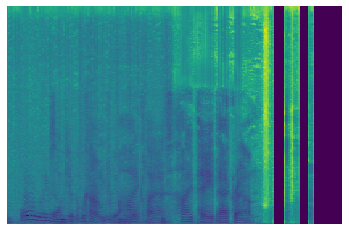

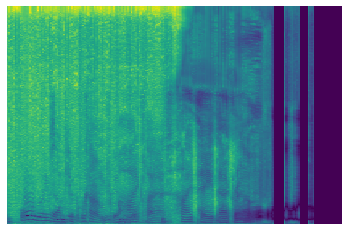

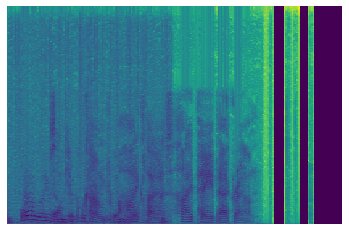

In [ ]:
#export
state = torch.load('../models/unet_4_binary')
model.load_state_dict(state)
model.cpu()
model.eval()
for i, (xb, yb) in tqdm(enumerate(valid_dl)):
    xb,yb = xb.detach().cpu(), [yb[i].detach().cpu() for i in range(2)]
    out = model(xb)
    mask1 = MaskBinary(out[:,:1,:,:])
    mask2 = MaskBinary(out[:,1:,:,:])
    
    sep = mask1*xb, mask2*xb
    sep = [sep[i].detach().cpu().squeeze() for i in range(len(sep))]
    sep = [real2complex(sep[i]) for i in range(len(sep))]
    spec1, spec2 = SpecImage(sep[0], 22050), SpecImage(sep[1], 22050)
    
    spec_mixed = xb.detach().cpu().squeeze()
    spec_mixed = real2complex(spec_mixed)
    spec_mixed = SpecImage(spec_mixed, 22050)
    
    spec1.show()
    spec2.show()
    spec_mixed.show()
    
    print(spec1.data[0][0])
    spec1 = Decibelify().decode(spec1)
    spec2 = Decibelify().decode(spec2)
    spec_mixed = Decibelify().decode(spec_mixed)
    
    print(spec1.data[0][0])
    audio1 = Spectify().decode(spec1)
    audio2 = Spectify().decode(spec2)
    audio_mixed = Spectify().decode(spec_mixed)
    
    print(audio1.data[0])
    audio1.listen()
    audio2.listen()
    audio_mixed.listen()
    break

In [ ]:
#export
state = torch.load('../models/unet_6_complex')
model.load_state_dict(state)
model.cpu()
model.eval()
for i, (xb, yb) in tqdm(enumerate(valid_dl)):
    xb,yb = xb.detach().cpu(), [yb[i].detach().cpu() for i in range(2)]
    out = model(xb)
    mask1 = MaskcIRM(out[:,:2,:,:])
    mask2 = MaskcIRM(out[:,2:,:,:])
    
    sep = mask1*xb, mask2*xb
    sep = [sep[i].detach().cpu().squeeze() for i in range(len(sep))]
    sep = [real2complex(sep[i]) for i in range(len(sep))]
    spec1, spec2 = SpecImage(sep[0], 22050), SpecImage(sep[1], 22050)
    
    spec_mixed = xb.detach().cpu().squeeze()
    spec_mixed = real2complex(spec_mixed)
    spec_mixed = SpecImage(spec_mixed, 22050)
    
    spec1.show()
    spec2.show()
    spec_mixed.show()
    
    print(spec1.data[0][0])
    spec1 = Decibelify().decode(spec1)
    spec2 = Decibelify().decode(spec2)
    spec_mixed = Decibelify().decode(spec_mixed)
    
    print(spec1.data[0][0])
    audio1 = Spectify().decode(spec1)
    audio2 = Spectify().decode(spec2)
    audio_mixed = Spectify().decode(spec_mixed)
    
    print(audio1.data[0])
    audio1.listen()
    audio2.listen()
    audio_mixed.listen()
    break